In [1]:
using NLsolve, Plots, Distributions, ProgressMeter, Statistics, StatsPlots

struct Calibration
    σ::Float64           # elasticity of relative demand with respect to price         
    γ::Vector{Float64}   # intensity in each good
    ϵ::Vector{Float64}   # elasticity of relative demand with respect to income in luxury good sector
end

cal = Calibration(
    0.5,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.6, 1.0, 1.65],       #ELASTICITIES
)

ρ=(cal.σ-1)/cal.σ

-1.0

In [2]:
#NH Utility Function
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    E=sum(p[i]*C[i] for i=1:length(C))
    out=1-sum(cal.γ[i]^(1/cal.σ)*(((p[i]/E)^(-cal.σ)*cal.γ[i])/u^((1-cal.σ)*cal.σ*cal.ϵ[i]))^ρ for i=1:length(C))
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C endowment
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    ExpNH=sum(cal.γ[i]*U^(cal.ϵ[i]*cal.σ*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    return [C1, C2, C3, U]#, U, E, ω]

end

NHUtility (generic function with 1 method)

In this example, prices were first given at p=[10.0, 2.0, 4.0].
However, this price level does not clear the market, we have demand that takes over endowment level in our economy

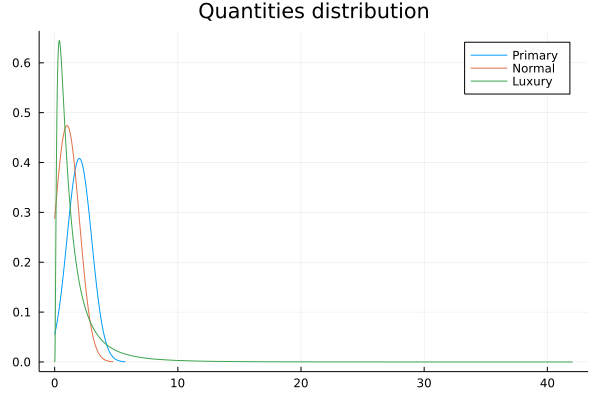

In [3]:
#Economy size
ng=3        #number of sector
na=300   #number of people
p=[9.5, 10.0, 11.0]

#Good matrix
G=zeros(na,ng)

#Quantities distribution for each person
D_P=Normal(2,1)
D_P = truncated(D_P, 0.0, Inf)
D_N=Normal(1,1)
D_N = truncated(D_N, 0.0, Inf)
D_L=LogNormal(0.02,1)
D_L = truncated(D_L, 0.0, Inf)


plot(D_P, title="Quantities distribution", label="Primary")
plot!(D_N, label="Normal")
plot!(D_L, label="Luxury")

In [4]:
#leading to a Expenditure vector evaluated by a distribution of good
p=[4.0, 5.0, 10.0]
Exp=[]

for j=1:na
    G[j,1]=rand(D_P)
    G[j,2]=rand(D_N)
    G[j,3]=rand(D_L)
end

for a = 1:Int(length(G)/ng)
    E=sum(p[i]*G[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end
G

300×3 Matrix{Float64}:
 2.14029   1.60677   0.321244
 2.27755   1.96075   1.04568
 2.95743   1.75203   3.0328
 1.58184   4.2206    0.274935
 2.2616    2.02257   1.89138
 3.11666   0.885474  4.48262
 1.54896   1.55538   0.650935
 1.19978   0.468673  1.26832
 1.88098   0.517864  0.508177
 0.694227  1.83533   0.698462
 ⋮                   
 3.89294   0.849105  2.20619
 2.5547    2.373     0.291335
 1.32368   0.09573   0.331898
 1.29038   1.62454   1.92856
 2.08729   0.113345  1.5872
 1.97058   0.831924  1.24437
 3.71753   0.949571  3.13773
 1.34155   2.55367   1.71852
 2.28582   1.18443   0.110595

Progress:   0%|▏                                        |  ETA: 0:05:06

Progress:   4%|█▋                                       |  ETA: 0:01:10

Progress:   5%|██                                       |  ETA: 0:01:00

Progress:   5%|██▎                                      |  ETA: 0:00:58

Progress:   6%|██▍                                      |  ETA: 0:00:55

Progress:   6%|██▌                                      |  ETA: 0:00:53

Progress:   7%|██▊                                      |  ETA: 0:00:52

Progress:   7%|██▉                                      |  ETA: 0:00:50

Progress:   7%|███                                      |  ETA: 0:00:49

Progress:   8%|███▎                                     |  ETA: 0:00:48

Progress:   8%|███▍                                     |  ETA: 0:00:46

Progress:   9%|███▌                                     |  ETA: 0:00:45

Progress:   9%|███▊                                     |  ETA: 0:00:45

Progress:   9%|███▉                                     |  ETA: 0:00:44

Progress:  10%|████                                     |  ETA: 0:00:43

Progress:  10%|████▏                                    |  ETA: 0:00:42

Progress:  11%|████▍                                    |  ETA: 0:00:41

Progress:  11%|████▌                                    |  ETA: 0:00:41

Progress:  11%|████▋                                    |  ETA: 0:00:40

Progress:  12%|████▉                                    |  ETA: 0:00:39

Progress:  12%|█████                                    |  ETA: 0:00:39

Progress:  13%|█████▏                                   |  ETA: 0:00:38

Progress:  13%|█████▍                                   |  ETA: 0:00:38

Progress:  13%|█████▌                                   |  ETA: 0:00:37

Progress:  14%|█████▋                                   |  ETA: 0:00:37

Progress:  14%|█████▉                                   |  ETA: 0:00:36

Progress:  15%|██████                                   |  ETA: 0:00:36

Progress:  15%|██████▏                                  |  ETA: 0:00:35

Progress:  15%|██████▍                                  |  ETA: 0:00:35

Progress:  16%|██████▌                                  |  ETA: 0:00:34

Progress:  16%|██████▋                                  |  ETA: 0:00:34

Progress:  17%|██████▊                                  |  ETA: 0:00:34

Progress:  17%|███████                                  |  ETA: 0:00:33

Progress:  17%|███████▏                                 |  ETA: 0:00:33

Progress:  18%|███████▎                                 |  ETA: 0:00:32

Progress:  18%|███████▌                                 |  ETA: 0:00:32

Progress:  19%|███████▋                                 |  ETA: 0:00:32

Progress:  19%|███████▊                                 |  ETA: 0:00:32

Progress:  19%|████████                                 |  ETA: 0:00:31

Progress:  20%|████████▏                                |  ETA: 0:00:31

Progress:  20%|████████▎                                |  ETA: 0:00:31

Progress:  21%|████████▌                                |  ETA: 0:00:30

Progress:  21%|████████▋                                |  ETA: 0:00:30

Progress:  21%|████████▊                                |  ETA: 0:00:30

Progress:  22%|█████████                                |  ETA: 0:00:30

Progress:  22%|█████████▏                               |  ETA: 0:00:29

Progress:  23%|█████████▎                               |  ETA: 0:00:29

Progress:  23%|█████████▍                               |  ETA: 0:00:29

Progress:  23%|█████████▋                               |  ETA: 0:00:29

Progress:  24%|█████████▊                               |  ETA: 0:00:28

Progress:  24%|█████████▉                               |  ETA: 0:00:28

Progress:  25%|██████████▏                              |  ETA: 0:00:28

Progress:  25%|██████████▎                              |  ETA: 0:00:28

Progress:  25%|██████████▍                              |  ETA: 0:00:27

Progress:  26%|██████████▋                              |  ETA: 0:00:27

Progress:  26%|██████████▊                              |  ETA: 0:00:27

Progress:  27%|██████████▉                              |  ETA: 0:00:27

Progress:  27%|███████████▏                             |  ETA: 0:00:26

Progress:  27%|███████████▎                             |  ETA: 0:00:26

Progress:  28%|███████████▍                             |  ETA: 0:00:26

Progress:  28%|███████████▌                             |  ETA: 0:00:26

Progress:  29%|███████████▊                             |  ETA: 0:00:26

Progress:  29%|███████████▉                             |  ETA: 0:00:25

Progress:  29%|████████████                             |  ETA: 0:00:25

Progress:  30%|████████████▎                            |  ETA: 0:00:25

Progress:  30%|████████████▍                            |  ETA: 0:00:25

Progress:  31%|████████████▌                            |  ETA: 0:00:25

Progress:  31%|████████████▊                            |  ETA: 0:00:24

Progress:  31%|████████████▉                            |  ETA: 0:00:24

Progress:  32%|█████████████                            |  ETA: 0:00:24

Progress:  32%|█████████████▎                           |  ETA: 0:00:24

Progress:  33%|█████████████▍                           |  ETA: 0:00:24

Progress:  33%|█████████████▌                           |  ETA: 0:00:23

Progress:  33%|█████████████▊                           |  ETA: 0:00:23

Progress:  34%|█████████████▉                           |  ETA: 0:00:23

Progress:  34%|██████████████                           |  ETA: 0:00:23

Progress:  35%|██████████████▏                          |  ETA: 0:00:23

Progress:  35%|██████████████▍                          |  ETA: 0:00:22

Progress:  35%|██████████████▌                          |  ETA: 0:00:22

Progress:  36%|██████████████▋                          |  ETA: 0:00:22

Progress:  36%|██████████████▉                          |  ETA: 0:00:22

Progress:  37%|███████████████                          |  ETA: 0:00:22

Progress:  37%|███████████████▏                         |  ETA: 0:00:22

Progress:  37%|███████████████▍                         |  ETA: 0:00:22

Progress:  38%|███████████████▌                         |  ETA: 0:00:21

Progress:  38%|███████████████▋                         |  ETA: 0:00:21

Progress:  39%|███████████████▉                         |  ETA: 0:00:21

Progress:  39%|████████████████                         |  ETA: 0:00:21

Progress:  39%|████████████████▏                        |  ETA: 0:00:21

Progress:  40%|████████████████▍                        |  ETA: 0:00:21

Progress:  40%|████████████████▌                        |  ETA: 0:00:20

Progress:  41%|████████████████▋                        |  ETA: 0:00:20

Progress:  41%|████████████████▊                        |  ETA: 0:00:20

Progress:  41%|█████████████████                        |  ETA: 0:00:20

Progress:  42%|█████████████████▏                       |  ETA: 0:00:20

Progress:  42%|█████████████████▎                       |  ETA: 0:00:20

Progress:  43%|█████████████████▌                       |  ETA: 0:00:19

Progress:  43%|█████████████████▋                       |  ETA: 0:00:19

Progress:  43%|█████████████████▊                       |  ETA: 0:00:19

Progress:  44%|██████████████████                       |  ETA: 0:00:19

Progress:  44%|██████████████████▏                      |  ETA: 0:00:19

Progress:  45%|██████████████████▎                      |  ETA: 0:00:19

Progress:  45%|██████████████████▌                      |  ETA: 0:00:19

Progress:  45%|██████████████████▋                      |  ETA: 0:00:19

Progress:  46%|██████████████████▊                      |  ETA: 0:00:18

Progress:  46%|███████████████████                      |  ETA: 0:00:18

Progress:  47%|███████████████████▏                     |  ETA: 0:00:18

Progress:  47%|███████████████████▎                     |  ETA: 0:00:18

Progress:  47%|███████████████████▍                     |  ETA: 0:00:18

Progress:  48%|███████████████████▋                     |  ETA: 0:00:18

Progress:  48%|███████████████████▊                     |  ETA: 0:00:18

Progress:  49%|███████████████████▉                     |  ETA: 0:00:17

Progress:  49%|████████████████████▏                    |  ETA: 0:00:17

Progress:  49%|████████████████████▎                    |  ETA: 0:00:17

Progress:  50%|████████████████████▍                    |  ETA: 0:00:17

Progress:  50%|████████████████████▋                    |  ETA: 0:00:17

Progress:  51%|████████████████████▊                    |  ETA: 0:00:17

Progress:  51%|████████████████████▉                    |  ETA: 0:00:16

Progress:  51%|█████████████████████▏                   |  ETA: 0:00:16

Progress:  52%|█████████████████████▎                   |  ETA: 0:00:16

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:16

Progress:  53%|█████████████████████▋                   |  ETA: 0:00:16

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:16

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:16

Progress:  54%|██████████████████████                   |  ETA: 0:00:15

Progress:  54%|██████████████████████▎                  |  ETA: 0:00:15

Progress:  55%|██████████████████████▍                  |  ETA: 0:00:15

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:15

Progress:  55%|██████████████████████▊                  |  ETA: 0:00:15

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:15

Progress:  56%|███████████████████████                  |  ETA: 0:00:15

Progress:  57%|███████████████████████▎                 |  ETA: 0:00:15

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:14

Progress:  57%|███████████████████████▌                 |  ETA: 0:00:14

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:14

Progress:  58%|███████████████████████▉                 |  ETA: 0:00:14

Progress:  59%|████████████████████████                 |  ETA: 0:00:14

Progress:  59%|████████████████████████▎                |  ETA: 0:00:14

Progress:  59%|████████████████████████▍                |  ETA: 0:00:13

Progress:  60%|████████████████████████▌                |  ETA: 0:00:13

Progress:  60%|████████████████████████▋                |  ETA: 0:00:13

Progress:  61%|████████████████████████▉                |  ETA: 0:00:13

Progress:  61%|█████████████████████████                |  ETA: 0:00:13

Progress:  61%|█████████████████████████▏               |  ETA: 0:00:13

Progress:  62%|█████████████████████████▎               |  ETA: 0:00:13

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:13

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:13

Progress:  63%|█████████████████████████▊               |  ETA: 0:00:12

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:12

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:12

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:12

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:12

Progress:  64%|██████████████████████████▍              |  ETA: 0:00:12

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:12

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:12

Progress:  66%|██████████████████████████▉              |  ETA: 0:00:12

Progress:  66%|███████████████████████████              |  ETA: 0:00:12

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:11

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:11

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:11

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:11

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:11

Progress:  68%|████████████████████████████             |  ETA: 0:00:11

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:11

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:11

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:10

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:10

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:10

Progress:  71%|█████████████████████████████            |  ETA: 0:00:10

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:10

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:10

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:10

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:10

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:09

Progress:  73%|██████████████████████████████           |  ETA: 0:00:09

Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:09

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:09

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:09

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:09

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:09

Progress:  76%|███████████████████████████████          |  ETA: 0:00:08

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:08

Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:08

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:08

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:08

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:08

Progress:  78%|████████████████████████████████         |  ETA: 0:00:08

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:07

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:07

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:07

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:07

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:07

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:07

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:07

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:07

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:06

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:06

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:06

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:06

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:06

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:06

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:06

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:05

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:05

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:05

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:05

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:04

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:04

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:04

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:04

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:04

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:03

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:03

Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:03

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:03

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:03

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:03

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:02

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:02

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:02

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:02

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:02

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:00

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


(W, D, Excess, p) = ([609.2777189458571, 381.000221305155, 442.9900153846803], [609.2777188964789, 381.00022095632477, 442.9900151509582], [-4.937828634865582e-8, -3.488302127152565e-7, -2.3372211899186368e-7], [0.9854389321543331, 4.258425863227633, 7.6359512603122806])


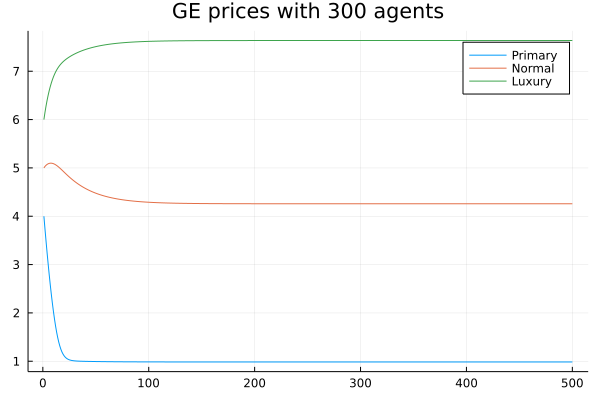

In [5]:
#Initial price level given
p=[4.0, 5.0, 6.0]

#Vectors and matrixes to store
W=zeros(ng)             #Endowment
D=zeros(ng)             #NH Demand
Excess=zeros(ng)

#We are looking for a pricepath at the GE.
pricepath=[]
#First value for excess, 
#1. if D>W Price increases
#2. if D<W Price drops
for i=1:ng
    W[i]=sum(G[j,i] for j=1:na)
    D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)
end

Excess=D-W

@showprogress for j=1:500
    pricepath=push!(pricepath, [p[1], p[2], p[3]])
    for i=1:ng
        p[i]=p[i]+0.001*Excess[i]
        W[i]=sum(G[j,i] for j=1:na)
        D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)        
    end
    Excess=D-W
sleep(0.000000001)
end

initial_p=[p[1], p[2], p[3]]

@show W,D, Excess, p

pricep=pricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices with 300 agents", label=["Primary" "Normal" "Luxury"])

Suppose we know design a supply shock where a fifth of the Primary good aggregate quantity destroyed.

In [6]:
Exp=[]
for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end

initial=[G Exp]
initial=sortslices(initial,dims=1,by=x->(x[4]),rev=false)
G=convert(Matrix{Float64},initial[:,[1,2,3]])

#after shock endowment level
n_G=copy(G)
s_shock=1/5
n_G[:,1]=G[:,1].*(1-s_shock)
n_G

300×3 Matrix{Float64}:
 0.804151   0.213094    0.206588
 1.15337    0.147581    0.246103
 0.728439   0.401552    0.17642
 1.05895    0.09573     0.331898
 1.94929    0.131486    0.20752
 2.50837    0.160238    0.128021
 0.403093   0.453814    0.32614
 1.31742    0.0994386   0.378809
 1.01092    0.435747    0.261013
 0.0808778  0.451893    0.441616
 ⋮                     
 2.31805    0.749928    6.35014
 1.98028    0.26717     6.76537
 2.16315    3.00251     5.44726
 1.79069    2.54757     5.76401
 1.02206    1.3024      6.59584
 2.46886    0.365987    7.12297
 2.13198    0.42689     7.9878
 1.53261    0.682196    8.02583
 0.560673   0.205035   11.3188

Then continue to look for equilibrium at GE prices to find another GE with supply shock.

Progress:   0%|▏                                        |  ETA: 0:00:47

Progress:   1%|▍                                        |  ETA: 0:00:32

Progress:   1%|▋                                        |  ETA: 0:00:32

Progress:   2%|▉                                        |  ETA: 0:00:30

Progress:   2%|█                                        |  ETA: 0:00:29

Progress:   3%|█▏                                       |  ETA: 0:00:29

Progress:   3%|█▍                                       |  ETA: 0:00:28

Progress:   4%|█▌                                       |  ETA: 0:00:29

Progress:   4%|█▊                                       |  ETA: 0:00:28

Progress:   5%|██                                       |  ETA: 0:00:27

Progress:   5%|██▏                                      |  ETA: 0:00:27

Progress:   6%|██▍                                      |  ETA: 0:00:27

Progress:   6%|██▌                                      |  ETA: 0:00:26

Progress:   7%|██▊                                      |  ETA: 0:00:27

Progress:   7%|██▉                                      |  ETA: 0:00:27

Progress:   7%|███                                      |  ETA: 0:00:27

Progress:   8%|███▎                                     |  ETA: 0:00:27

Progress:   8%|███▌                                     |  ETA: 0:00:27

Progress:   9%|███▊                                     |  ETA: 0:00:26

Progress:  10%|███▉                                     |  ETA: 0:00:26

Progress:  10%|████▏                                    |  ETA: 0:00:26

Progress:  11%|████▍                                    |  ETA: 0:00:25

Progress:  11%|████▋                                    |  ETA: 0:00:25

Progress:  12%|████▊                                    |  ETA: 0:00:25

Progress:  12%|█████                                    |  ETA: 0:00:25

Progress:  13%|█████▏                                   |  ETA: 0:00:25

Progress:  13%|█████▍                                   |  ETA: 0:00:25

Progress:  14%|█████▋                                   |  ETA: 0:00:24

Progress:  14%|█████▉                                   |  ETA: 0:00:24

Progress:  15%|██████▏                                  |  ETA: 0:00:24

Progress:  15%|██████▍                                  |  ETA: 0:00:23

Progress:  16%|██████▌                                  |  ETA: 0:00:23

Progress:  16%|██████▊                                  |  ETA: 0:00:23

Progress:  17%|██████▉                                  |  ETA: 0:00:23

Progress:  17%|███████▏                                 |  ETA: 0:00:23

Progress:  18%|███████▍                                 |  ETA: 0:00:23

Progress:  18%|███████▌                                 |  ETA: 0:00:22

Progress:  19%|███████▊                                 |  ETA: 0:00:22

Progress:  20%|████████                                 |  ETA: 0:00:22

Progress:  20%|████████▎                                |  ETA: 0:00:22

Progress:  21%|████████▌                                |  ETA: 0:00:22

Progress:  21%|████████▊                                |  ETA: 0:00:21

Progress:  22%|████████▉                                |  ETA: 0:00:22

Progress:  22%|█████████                                |  ETA: 0:00:22

Progress:  22%|█████████▏                               |  ETA: 0:00:21

Progress:  23%|█████████▍                               |  ETA: 0:00:21

Progress:  23%|█████████▌                               |  ETA: 0:00:21

Progress:  24%|█████████▋                               |  ETA: 0:00:21

Progress:  24%|█████████▉                               |  ETA: 0:00:21

Progress:  24%|██████████                               |  ETA: 0:00:21

Progress:  25%|██████████▏                              |  ETA: 0:00:22

Progress:  25%|██████████▍                              |  ETA: 0:00:22

Progress:  26%|██████████▌                              |  ETA: 0:00:22

Progress:  26%|██████████▋                              |  ETA: 0:00:22

Progress:  26%|██████████▉                              |  ETA: 0:00:21

Progress:  27%|███████████                              |  ETA: 0:00:22

Progress:  28%|███████████▍                             |  ETA: 0:00:21

Progress:  28%|███████████▌                             |  ETA: 0:00:21

Progress:  29%|███████████▊                             |  ETA: 0:00:21

Progress:  29%|███████████▉                             |  ETA: 0:00:22

Progress:  29%|████████████                             |  ETA: 0:00:22

Progress:  29%|████████████                             |  ETA: 0:00:22

Progress:  30%|████████████▏                            |  ETA: 0:00:23

Progress:  30%|████████████▎                            |  ETA: 0:00:23

Progress:  30%|████████████▌                            |  ETA: 0:00:23

Progress:  31%|████████████▋                            |  ETA: 0:00:23

Progress:  31%|████████████▊                            |  ETA: 0:00:23

Progress:  32%|█████████████                            |  ETA: 0:00:22

Progress:  32%|█████████████▏                           |  ETA: 0:00:22

Progress:  32%|█████████████▎                           |  ETA: 0:00:22

Progress:  33%|█████████████▍                           |  ETA: 0:00:22

Progress:  33%|█████████████▌                           |  ETA: 0:00:22

Progress:  33%|█████████████▊                           |  ETA: 0:00:22

Progress:  34%|█████████████▉                           |  ETA: 0:00:22

Progress:  34%|██████████████                           |  ETA: 0:00:22

Progress:  34%|██████████████▏                          |  ETA: 0:00:22

Progress:  35%|██████████████▎                          |  ETA: 0:00:22

Progress:  35%|██████████████▍                          |  ETA: 0:00:22

Progress:  36%|██████████████▋                          |  ETA: 0:00:22

Progress:  36%|██████████████▊                          |  ETA: 0:00:22

Progress:  36%|██████████████▉                          |  ETA: 0:00:22

Progress:  37%|███████████████                          |  ETA: 0:00:22

Progress:  37%|███████████████▏                         |  ETA: 0:00:22

Progress:  37%|███████████████▍                         |  ETA: 0:00:22

Progress:  38%|███████████████▌                         |  ETA: 0:00:22

Progress:  38%|███████████████▋                         |  ETA: 0:00:22

Progress:  39%|███████████████▉                         |  ETA: 0:00:21

Progress:  39%|████████████████                         |  ETA: 0:00:21

Progress:  39%|████████████████▏                        |  ETA: 0:00:21

Progress:  40%|████████████████▍                        |  ETA: 0:00:21

Progress:  40%|████████████████▍                        |  ETA: 0:00:21

Progress:  40%|████████████████▌                        |  ETA: 0:00:21

Progress:  40%|████████████████▋                        |  ETA: 0:00:22

Progress:  41%|████████████████▊                        |  ETA: 0:00:21

Progress:  41%|████████████████▉                        |  ETA: 0:00:21

Progress:  42%|█████████████████                        |  ETA: 0:00:21

Progress:  42%|█████████████████▏                       |  ETA: 0:00:21

Progress:  42%|█████████████████▎                       |  ETA: 0:00:21

Progress:  43%|█████████████████▌                       |  ETA: 0:00:21

Progress:  43%|█████████████████▋                       |  ETA: 0:00:21

Progress:  43%|█████████████████▊                       |  ETA: 0:00:21

Progress:  44%|██████████████████                       |  ETA: 0:00:20

Progress:  44%|██████████████████▏                      |  ETA: 0:00:20

Progress:  45%|██████████████████▎                      |  ETA: 0:00:20

Progress:  45%|██████████████████▍                      |  ETA: 0:00:20

Progress:  45%|██████████████████▌                      |  ETA: 0:00:20

Progress:  45%|██████████████████▋                      |  ETA: 0:00:20

Progress:  46%|██████████████████▊                      |  ETA: 0:00:20

Progress:  46%|███████████████████                      |  ETA: 0:00:20

Progress:  47%|███████████████████▏                     |  ETA: 0:00:19

Progress:  47%|███████████████████▎                     |  ETA: 0:00:19

Progress:  47%|███████████████████▍                     |  ETA: 0:00:19

Progress:  48%|███████████████████▋                     |  ETA: 0:00:19

Progress:  48%|███████████████████▊                     |  ETA: 0:00:19

Progress:  49%|███████████████████▉                     |  ETA: 0:00:19

Progress:  49%|████████████████████▏                    |  ETA: 0:00:18

Progress:  49%|████████████████████▎                    |  ETA: 0:00:18

Progress:  50%|████████████████████▍                    |  ETA: 0:00:18

Progress:  50%|████████████████████▋                    |  ETA: 0:00:18

Progress:  51%|████████████████████▊                    |  ETA: 0:00:18

Progress:  51%|████████████████████▉                    |  ETA: 0:00:18

Progress:  51%|█████████████████████▏                   |  ETA: 0:00:18

Progress:  52%|█████████████████████▎                   |  ETA: 0:00:17

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:17

Progress:  53%|█████████████████████▋                   |  ETA: 0:00:17

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:17

Progress:  53%|█████████████████████▉                   |  ETA: 0:00:17

Progress:  54%|██████████████████████                   |  ETA: 0:00:17

Progress:  54%|██████████████████████▎                  |  ETA: 0:00:17

Progress:  55%|██████████████████████▍                  |  ETA: 0:00:16

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:16

Progress:  55%|██████████████████████▊                  |  ETA: 0:00:16

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:16

Progress:  56%|███████████████████████                  |  ETA: 0:00:16

Progress:  57%|███████████████████████▎                 |  ETA: 0:00:16

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:16

Progress:  57%|███████████████████████▌                 |  ETA: 0:00:15

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:15

Progress:  58%|███████████████████████▉                 |  ETA: 0:00:15

Progress:  59%|████████████████████████                 |  ETA: 0:00:15

Progress:  59%|████████████████████████▏                |  ETA: 0:00:15

Progress:  59%|████████████████████████▎                |  ETA: 0:00:15

Progress:  60%|████████████████████████▍                |  ETA: 0:00:15

Progress:  60%|████████████████████████▋                |  ETA: 0:00:15

Progress:  60%|████████████████████████▊                |  ETA: 0:00:14

Progress:  61%|████████████████████████▉                |  ETA: 0:00:14

Progress:  61%|█████████████████████████▏               |  ETA: 0:00:14

Progress:  62%|█████████████████████████▎               |  ETA: 0:00:14

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:14

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:14

Progress:  63%|█████████████████████████▊               |  ETA: 0:00:13

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:13

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:13

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:13

Progress:  64%|██████████████████████████▍              |  ETA: 0:00:13

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:13

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:13

Progress:  66%|██████████████████████████▉              |  ETA: 0:00:12

Progress:  66%|███████████████████████████              |  ETA: 0:00:12

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:12

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:12

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:12

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:12

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:11

Progress:  68%|████████████████████████████             |  ETA: 0:00:11

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:11

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:11

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:11

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:11

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:11

Progress:  71%|█████████████████████████████            |  ETA: 0:00:10

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:10

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:10

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:10

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:10

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:10

Progress:  73%|██████████████████████████████           |  ETA: 0:00:09

Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:09

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:09

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:09

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:09

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:09

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:09

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:09

Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:09

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:08

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:08

Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:08

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:08

Progress:  78%|████████████████████████████████         |  ETA: 0:00:08

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:08

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:08

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:08

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:07

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:07

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:07

Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:07

Progress:  81%|█████████████████████████████████        |  ETA: 0:00:07

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:07

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:07

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:07

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:07

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:06

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:06

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:06

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:06

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:06

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:06

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:06

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:05

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:05

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:05

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:05

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:04

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:04

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:04

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:04

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:04

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:03

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:03

Progress:  92%|█████████████████████████████████████▌   |  ETA: 0:00:03

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:03

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:03

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:03

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:03

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:02

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:02

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:02

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:00

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


(W, D, Excess) = ([487.4221751566856, 381.0002213051549, 442.99001538468065], [487.42217508799206, 381.0002211239321, 442.9900150442054], [-6.869356639072066e-8, -1.812228447306552e-7, -3.404752533242572e-7])


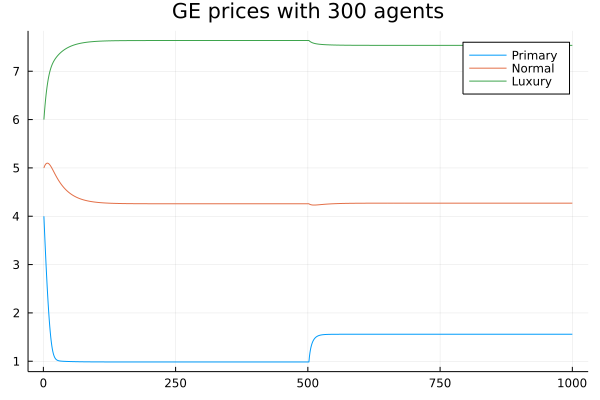

In [7]:
shockpricepath=pricepath
initial_p=[p[1], p[2], p[3]]
@showprogress for j=1:500
    shockpricepath=push!(shockpricepath, [p[1], p[2], p[3]])
    for i=1:ng
        p[i]=p[i]+0.001*Excess[i]
        W[i]=sum(n_G[j,i] for j=1:na)
        D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)        
    end
    Excess=D-W
sleep(0.00000001)
end

after_shock_p=p

pricep=shockpricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

@show W,D, Excess
plot([p_p p_n p_l], title="GE prices with 300 agents", label=["Primary" "Normal" "Luxury"])

In [8]:
initial_p, after_shock_p,p

([0.9854389321543331, 4.258425863227633, 7.6359512603122806], [1.559257061944775, 4.2713136796720255, 7.535695538811946], [1.559257061944775, 4.2713136796720255, 7.535695538811946])

In [9]:
A=[]
B=[]

Exp=[]
C_P=[]
C_N=[]
C_L=[]
U=[]
#Deciles
for j=1:10
    for i=1:na/10
        A=push!(A,Int(i))
        B=push!(B,Int(j))
    end
end

#Initial endowment with GE prices

for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    C1=NHUtility(G[a,:],initial_p)[1]
    C2=NHUtility(G[a,:],initial_p)[2]
    C3=NHUtility(G[a,:],initial_p)[3]
    Utility=NHUtility(G[a,:],initial_p)[4]

    
    Exp=push!(Exp,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
#initial=sortslices(initial,dims=1,by=x->(x[1]),rev=false)

initial= [A U G Exp C_P C_N C_L]

300×9 Matrix{Any}:
  1    0.879434  1.00519   0.213094   …  0.614048  0.291617  0.213275
  2    1.07169   1.44171   0.147581      0.672486  0.325747  0.246014
  3    1.08312   0.910549  0.401552      0.67578   0.32769   0.247908
  4    1.21432   1.32368   0.09573       0.712403  0.349421  0.269306
  5    1.354     2.43662   0.131486      0.749213  0.371499  0.291433
  6    1.45216   3.13546   0.160238   …  0.773928  0.386449  0.306629
  7    1.53557   0.503866  0.453814      0.79426   0.398823  0.319331
  8    1.54518   1.64678   0.0994386     0.796567  0.400231  0.320784
  9    1.62294   1.26365   0.435747      0.814959  0.411487  0.332448
 10    1.77805   0.101097  0.451893      0.850348  0.433293  0.355296
  ⋮                                   ⋱                      
 22   57.1327    2.89757   0.749928      4.54933   3.27964   4.72621
 23   58.1832    2.47536   0.26717       4.59091   3.31565   4.79227
 24   60.9263    2.70394   3.00251       4.69781   3.40852   4.96352
 25   60.960

In [10]:
#After the shock, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for a = 1:Int(length(n_G)/ng)
    E=sum(initial_p[i]*n_G[a,i] for i = 1:ng)
    C1=NHUtility(n_G[a,:],initial_p)[1]
    C2=NHUtility(n_G[a,:],initial_p)[2]
    C3=NHUtility(n_G[a,:],initial_p)[3]
    Utility=NHUtility(n_G[a,:],initial_p)[4]

    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
after_shock=[A U n_G Exp_ng C_P C_N C_L]

300×9 Matrix{Any}:
  1    0.799567  0.804151   0.213094   …  0.587835  0.276523  0.199131
  2    0.949538  1.15337    0.147581      0.636057  0.304395  0.225412
  3    1.00508   0.728439   0.401552      0.652904  0.314239  0.234861
  4    1.09686   1.05895    0.09573       0.67972   0.330017  0.250181
  5    1.1324    1.94929    0.131486      0.689791  0.335976  0.256021
  6    1.1622    2.50837    0.160238   …  0.69811   0.340912  0.260881
  7    1.48658   0.403093   0.453814      0.782388  0.391589  0.311892
  8    1.38673   1.31742    0.0994386     0.757554  0.376533  0.296531
  9    1.49873   1.01092    0.435747      0.785351  0.393393  0.313744
 10    1.76768   0.0808778  0.451893      0.848032  0.43186   0.353785
  ⋮                                    ⋱                      
 22   56.2781    2.31805    0.749928      4.51523   3.25015   4.67226
 23   57.4492    1.98028    0.26717       4.5619    3.29052   4.74614
 24   60.1143    2.16315    3.00251       4.66642   3.38121   4.9130

In [11]:
loss=(initial-after_shock)./initial

300×9 Matrix{Float64}:
 0.0  0.0908163   0.2  0.0  0.0  …  0.0426889   0.05176     0.0663176
 0.0  0.113984    0.2  0.0  0.0     0.0541704   0.0655479   0.0837451
 0.0  0.0720487   0.2  0.0  0.0     0.0338521   0.0410496   0.0526314
 0.0  0.0967281   0.2  0.0  0.0     0.045876    0.0555333   0.0710183
 0.0  0.16366     0.2  0.0  0.0     0.0793122   0.0956205   0.121508
 0.0  0.199681    0.2  0.0  0.0  …  0.0979658   0.117836    0.149196
 0.0  0.0319047   0.2  0.0  0.0     0.0149473   0.0181362   0.023296
 0.0  0.102547    0.2  0.0  0.0     0.0489766   0.0592107   0.0756068
 0.0  0.076531    0.2  0.0  0.0     0.03633     0.0439721   0.0562614
 0.0  0.00583363  0.2  0.0  0.0     0.00272354  0.00330685  0.00425399
 ⋮                               ⋱                          
 0.0  0.0149571   0.2  0.0  0.0     0.00749542  0.00899001  0.0114139
 0.0  0.0126146   0.2  0.0  0.0     0.00631986  0.00758052  0.00962569
 0.0  0.0133266   0.2  0.0  0.0     0.00668289  0.00801465  0.010175
 0.0  0.

In [12]:
Utility_loss=loss[:,2]

300-element Vector{Float64}:
 0.09081634030560688
 0.1139839598218381
 0.07204872664173143
 0.0967280658361439
 0.16365984767510078
 0.19968099104680415
 0.03190472893354878
 0.10254717805419052
 0.07653101438488213
 0.005833628638842455
 ⋮
 0.014957054336875655
 0.012614591126749616
 0.013326582527200112
 0.011030957902234614
 0.006288550562328829
 0.014689007568895992
 0.011400172164960526
 0.008116989015135492
 0.0022110829307023312

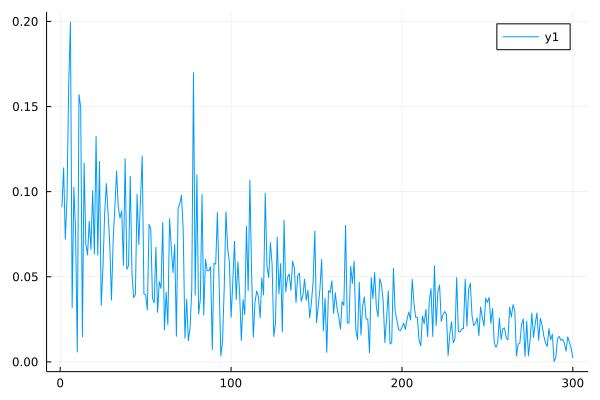

In [13]:
plot(Utility_loss)

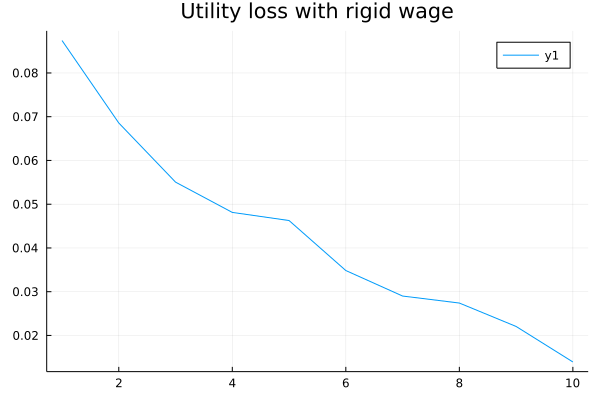

In [14]:
na=30
decile=10
dec=reshape(Utility_loss,(na,decile))
dec=mean(dec,dims=1)
dec=transpose(dec)

plot(dec, title="Utility loss with rigid wage")